In [3]:
import pandas as pd
import numpy as np
import pandas

In [19]:
# 1. 데이터 가져오기
def load_dataset():
    # 데이터 load
    data = pd.read_csv("data/credit_card_churn.csv", na_values='Unknown')
    # 컬럼명 소문자로 변경
    data.columns = data.columns.str.lower()
    data.rename(columns={'attrition_flag': 'churn'}, inplace=True)
    
    ## 불필요 칼럼 삭제
    data.drop(
        columns=[
            'clientnum',
            'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1',
            'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2'
        ], 
        inplace=True
    )
    return data

df = load_dataset()

In [20]:

# 2. 데이터 전처리 (이상치, 결측치, Feature Engineering)

# 2-1. 데이터 전처리 > 이상치(Outlier) 
# - IQR 식별 -> 극단치 제거
#  2-1-1. Outlier 식별: IQR(Inter quantile Range) 을 이용해 Outlier 식별 
def find_outliers(df, column_name, whis=1.5):
    """
    분위수 기준으로 이상치를 찾는 함수

    Parameters:
    df (pd.DataFrame): 데이터프레임
    column_name (str): 이상치를 찾을 컬럼명

    Returns:
    pd.Series: 이상치 값들
    """
    q1, q3 = df[column_name].quantile(q=[0.25, 0.75])
    iqr = q3 - q1
    iqr *= whis
    return df.loc[~df[column_name].between(q1 - iqr, q3 + iqr)]

# ==> ["customer_age", "total_trans_ct"] 두 칼럼의 이상치를 삭제하기로 결정

#  2-1-2. Outlier 제거: 삭제할 이상치 index를 찾아서 drop
def delete_outliers(df, columns, whis=1.5):
    index_list = []
    _df = df.copy()
    
    for col in columns: 
        outliers_column_index = find_outliers(df, col, whis=whis)
        index_list.extend(outliers_column_index.index)
        
        
    _df = _df.drop(index=index_list)
        
    _df.reset_index(drop=True, inplace=True)
    
    return _df

outlier_columns = ["customer_age", "total_trans_ct"]
df = delete_outliers(df, outlier_columns)

In [21]:
# 2-2. 데이터 전처리 > 결측치 대체(imputation) 
# - SimpleImputer: 최빈값으로 대치(column 2개) + 사용자 정의 imputer: 비율에 따른 대치(column 1개)
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

#  2-2-1. SimpleImputer(strategy=최빈값) 
simple_imputer = SimpleImputer(strategy='most_frequent')

#  2-2-2. ProportionalImputer(사용자 정의)
class ProportionalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.fill_values = {}

    def fit(self, X, y=None):
        for column in self.columns:
            value_counts = X[column].value_counts(normalize=True)
            self.fill_values[column] = (value_counts.index, value_counts.values)
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.columns:

            nan_count = X[column].isna().sum()
            if nan_count > 0:
                fill_values = np.random.choice(
                    self.fill_values[column][0], size=nan_count, p=self.fill_values[column][1]
                )
                X.loc[X[column].isna(), column] = fill_values
        return X

def simple_impute_most_frequent(df, columns):
    imputer = SimpleImputer(strategy='most_frequent')
    df[columns] = imputer.fit_transform(df[columns])
    return df
def proportional_impute(df, columns):
    imputer = ProportionalImputer(columns=columns)
    imputer.fit(df)
    return imputer.transform(df)

df = simple_impute_most_frequent(df, ['education_level', 'marital_status'])
df = proportional_impute(df, ['income_category'])

In [22]:
# 2-3. 데이터 전처리 > Feature Engineering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 2-3-1. 라벨 인코딩(Label Encoding) - 'gender'
# 이유: 이진 변수의 경우 모델 성능에 큰 차이가 없으므로, 간단히 라벨 인코딩을 사용하기로 함.
label_encoder = LabelEncoder()

df['gender'] = label_encoder.fit_transform(df['gender'])

# 2-3-2. 순서 인코딩 (Ordinal Encoding) - 'education_level'
education_order = {"Uneducated": 0, "High School": 1, "College": 2, "Graduate": 3, "Post-Graduate": 4, "Doctorate": 5}
df['education_level'] = df['education_level'].map(education_order)

# 2-3-3. mapping - 'gender'
df['churn'] = df['churn'].map({"Existing Customer": 0, "Attrited Customer": 1})

# 2-3-4. 원핫 인코딩(One-Hot encoding) - 'marital_status', 'card_category', 'income_category'
# 이유: 순서가 없고 각 값이 독립적인 범주형 데이터으로서 순서나 크기 정보 없이 각각 독립적인 특성으로 변환되므로, 머신러닝 모델에서 더 잘 해석될 가능성이 있다고 보아 원핫 인코딩 하기로 결정.
ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)

columns_to_ohe_encode = [ 'marital_status', 'card_category', 'income_category']
encoded_data = ohe_encoder.fit_transform(df[columns_to_ohe_encode])

# 인코딩된 데이터를 dataframe으로 변환
encoded_df = pd.DataFrame(encoded_data, columns=ohe_encoder.get_feature_names_out(columns_to_ohe_encode))
# 기존 df와 인코딩된 dataframe을 병합하고 원본 열 삭제
df = pd.concat([df.drop(columns=columns_to_ohe_encode), encoded_df], axis=1)

In [25]:
df

,churn,customer_age,gender,dependent_count,education_level,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,...,avg_utilization_ratio,marital_status_Married,marital_status_Single,card_category_Gold,card_category_Platinum,card_category_Silver,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K
0,0,45,1,3,1,39,5,1,3,12691.0,...,0.061,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,49,0,5,3,44,6,1,2,8256.0,...,0.105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,51,1,3,3,36,4,1,0,3418.0,...,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,40,0,4,1,34,3,4,1,3313.0,...,0.760,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,40,1,3,0,21,5,1,0,4716.0,...,0.000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10118,0,50,1,2,3,40,3,2,3,4003.0,...,0.462,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10119,1,41,1,2,3,25,4,2,3,4277.0,...,0.511,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10120,1,44,0,1,1,36,5,3,4,5409.0,...,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10121,1,30,1,2,3,36,4,3,3,5281.0,...,0.000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


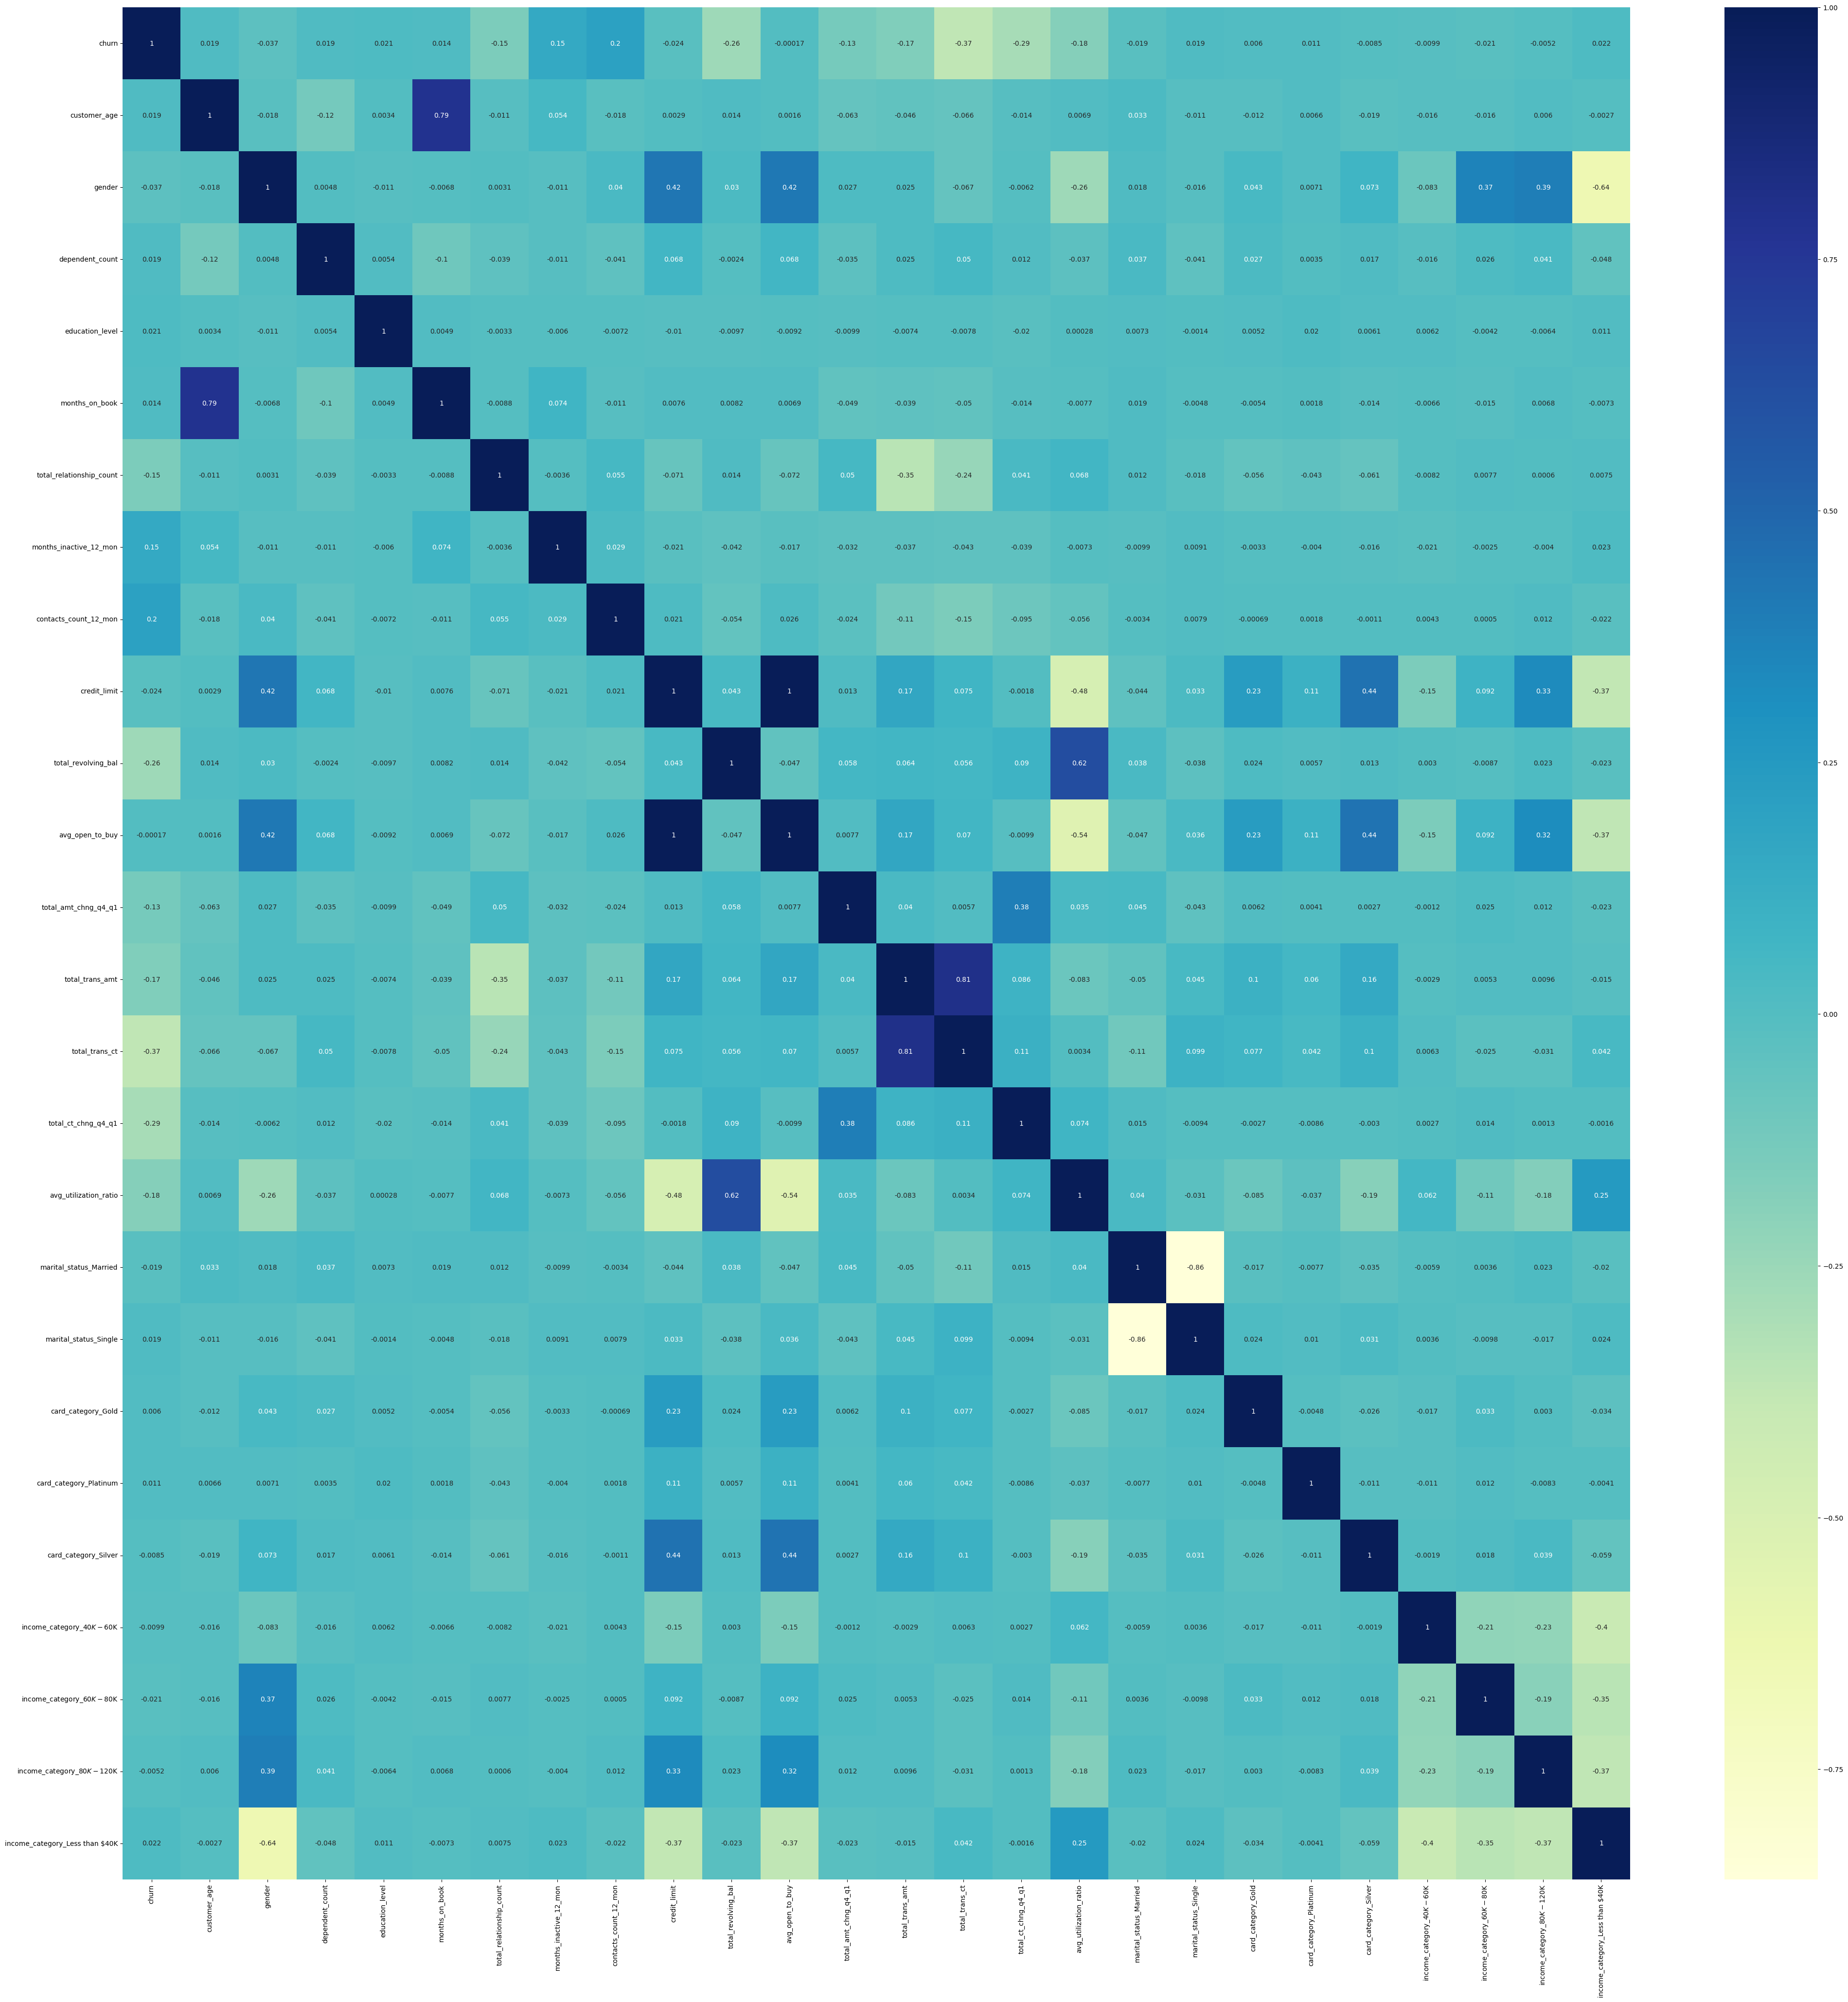

In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(figsize=(50, 50))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [24]:
## 데이터 스플릿

from sklearn.model_selection import train_test_split
X = df.drop(["churn"], axis=1)
y = df["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [11]:
## Linear SVC

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Linear SVM - 규제 hyper parameter: C
## 작을 수록 규제 강도가 큼.
C_list = [1] # 0 초과의 값을 지정. 실수. default: 1        [0.001, 0.01, 0.1, 1, 10, 100]  시간이 너무오래걸려서 하나만 해봄
train_acc_list = []
test_acc_list = []

for C in C_list:
    svm = SVC(
        kernel="linear", # 커널 함수 지정. 선형SVM: linear, 비선형SVM: rbf(기본), poly, sigmoid
        C=C,             # soft - hard margin 설정. (작을수록 강한 규제)
        random_state=0
    )
    # 학습
    svm.fit(X_train, y_train)
    # 검증
    ## 추론
    pred_train = svm.predict(X_train)
    pred_test = svm.predict(X_test)
    ## 평가
    train_acc_list.append(accuracy_score(y_train, pred_train))
    test_acc_list.append(accuracy_score(y_test, pred_test))

In [12]:
import pandas as pd
import numpy as np
df = pd.DataFrame({
    "C":np.log10(C_list),
    # "C": C_list,
    "Train": train_acc_list,
    "Test": test_acc_list
})
df.set_index("C")

,Train,Test
C,,
0.0,0.885801,0.881865


In [17]:
df.set_index("C").plot();

KeyError: "None of ['C'] are in the columns"

In [27]:
## KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_list = range(1, 11)                        # range(1, 11)  시간이 오래걸령
train_acc_list, test_acc_list = [], []

for k in k_list:
    # k값 넣어서 모델 생성 
    knn = KNeighborsClassifier(n_neighbors=k)
    # 학습
    knn.fit(X_train, y_train)
    # 검증 -> 검증결과 LIST에 추가.
    train_acc_list.append(accuracy_score(y_train, knn.predict(X_train)))
    test_acc_list.append(accuracy_score(y_test, knn.predict(X_test)))

In [28]:
import pandas as pd
df = pd.DataFrame({
    "train":train_acc_list,
    "test":test_acc_list
}, index=k_list)
df.rename_axis(index="K", columns="Dataset", inplace=True)
df

Dataset,train,test
K,,
1,1.000000,0.875148
2,0.930585,0.885421
3,0.934141,0.888977
4,0.917677,0.889372
5,0.915964,0.894508
6,0.909773,0.888977
7,0.912408,0.897669
8,0.907007,0.895298
9,0.907929,0.894903


<Axes: xlabel='K'>

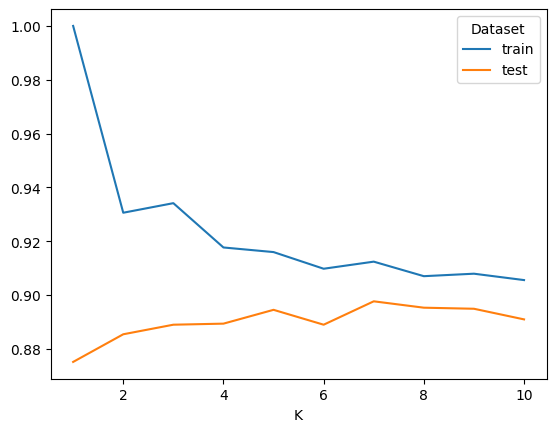

In [29]:
df.plot()

In [ ]:
# ML 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

# Logistic Regression

# Decision Tree

# Random Forest

# Gradient Boosting

# XGBoost

# SVM(Support Vector Machine)

# KNN(K-Nearest Neighbors)